In [2]:
import os
import sys
import re
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import seaborn as sns
%matplotlib inline

# Enable relative imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from text.analytics import TermFreqInverseDocFreq

### Clean up the data to remove duplicates, nulls and noise (wikipedia redirects)

In [6]:
fauna = pd.read_csv('../data/fauna.csv.gz', compression='gzip')
print('fauna.shape before nulls removed', fauna.shape)
fauna = fauna[fauna['class'].notnull()]
fauna = fauna[fauna['text'].notnull()]
fauna = fauna[fauna['order'].notnull()]
print('fauna.shape after nulls removed', fauna.shape)
print('fauna.shape before duplicates removed', fauna.shape)
fauna = fauna.drop_duplicates(['page-id'], keep='first')
print('fauna.shape after duplicates removed', fauna.shape)
fauna = fauna.drop(fauna[fauna['text'].str.contains('This is a redirect')].index)
print('fauna.shape after redirects dropped', fauna.shape)
print(fauna.shape)
fauna.head()

fauna.shape before nulls removed (44124, 10)
fauna.shape after nulls removed (44124, 10)
fauna.shape before duplicates removed (44124, 10)
fauna.shape after duplicates removed (44124, 10)
fauna.shape after redirects dropped (44124, 10)
(44124, 10)


,class,family,genus,kingdom,order,page-id,phylum,species,text,title
0,amphibia,ranidae,rana,animalia,anura,3451749,chordata,rboylii,The foothill yellow-legged frog (Rana boylii) ...,Foothill yellow-legged frog
1,mammalia,bovidae,pantholopshodgson18342,animalia,artiodactyla,1369072,chordata,phodgsonii,The Tibetan antelope or chiru (Pantholops hodg...,Tibetan antelope
2,mammalia,bovidae,damaliscus,animalia,artiodactyla,26625724,chordata,dsuperstes,The Bangweulu tsessebe (Damaliscus superstes) ...,Bangweulu tsessebe
3,mammalia,tayassuidae,catagonusameghino1904,animalia,artiodactyla,1709509,chordata,cbrachydontuscmetropolitanuscstenocephaluscwag...,The Chacoan peccary or tagua (Catagonus wagner...,Chacoan peccary
4,aves,opisthocomidae,opisthocomusilliger1811,animalia,opisthocomiformes,262734,chordata,ohoazin,"The hoatzin (Opisthocomus hoazin), also known ...",Hoatzin


### Save the cleaned up data

In [8]:
#fauna.to_csv('../data/fauna.csv.gz', compression='gzip', index=False)

### Visualize the number of records in each class

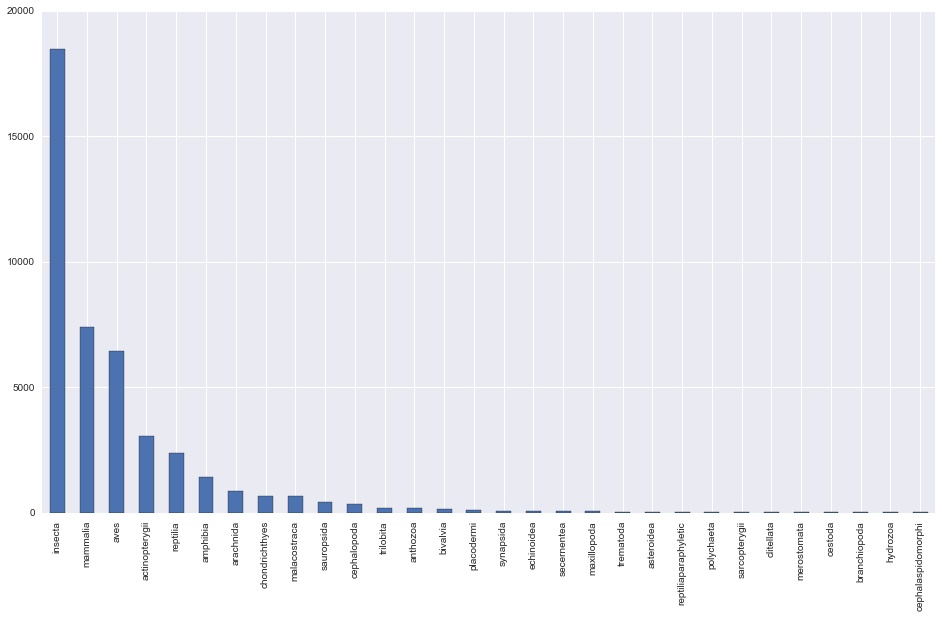

In [9]:
classes = fauna['class'].value_counts()
figure(figsize=(16, 9))
classes[0:30].plot(kind="bar")

### Basic filtering on various fields

In [10]:
fauna[fauna['title']=='Red panda']

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
7064,mammalia,ailuridae,ailurusfcuvier1825,animalia,carnivora,26441,chordata,afulgensfcuvier1825,"The red panda (Ailurus fulgens), also called t...",Red panda


### Create a TFIDF Table

In [11]:
tfidf = TermFreqInverseDocFreq()
tfidf.create(fauna, 'text', True)

### Plot the term count over iterations

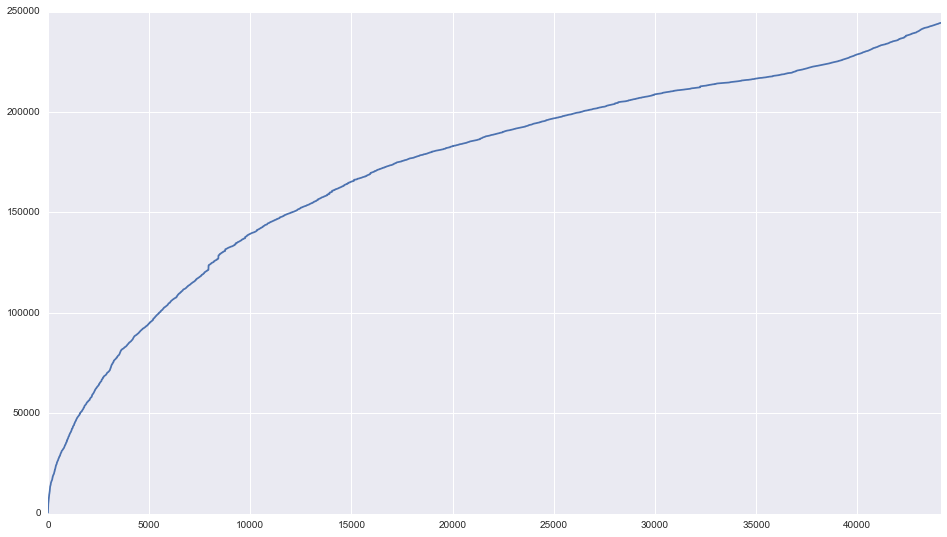

In [12]:
term_count_series = pd.Series(tfidf.term_count_over_iterations)
figure(figsize=(16, 9))
term_count_series.plot()

### Comparing similar and disimilar species

In [13]:
bears = fauna[fauna['title'].str.contains('bear')]
bears.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
367,mammalia,ursidae,ursus,animalia,carnivora,616975,chordata,uthibetanus,"The Asian black bear (Ursus thibetanus, previo...",Asian black bear
1091,mammalia,suidae,sus,animalia,artiodactyla,4404236,chordata,sbarbatus,"The Bornean bearded pig (Sus barbatus), also k...",Bornean bearded pig
1453,mammalia,ursidae,ursus,animalia,carnivora,5331257,chordata,uinopinatusdisputed,MacFarlane's bear is a proposed extinct specie...,MacFarlane's bear
2182,mammalia,ursidae,ursus,animalia,carnivora,4402,chordata,uarctos,The brown bear (Ursus arctos) is a large bear ...,Brown bear
2189,mammalia,ursidae,melursusmeyer1793,animalia,carnivora,399740,chordata,mursinus,"The sloth bear (Melursus ursinus), also known ...",Sloth bear


In [14]:
fish = fauna[fauna['title'].str.contains('fish')]
fish.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
51,scyphozoa,cyaneidae,cyaneapéronandlesueur1809,animalia,semaeostomeae,28093883,cnidaria,NaN,Cyanea is a cosmopolitan genus of stinging jel...,Cyanea (jellyfish)
77,aves,alcedinidae,halcyon,animalia,coraciiformes,568859,chordata,hsmyrnensis,The white-throated kingfisher (Halcyon smyrnen...,White-throated kingfisher
87,aves,alcedinidae,todiramphus,animalia,coraciiformes,12432037,chordata,tleucopygius,The ultramarine kingfisher (Todiramphus leucop...,Ultramarine kingfisher
102,aves,alcedinidae,lacedolreichenbach1851,animalia,coraciiformes,11900398,chordata,lpulchella,The banded kingfisher (Lacedo pulchella) is a ...,Banded kingfisher
205,actinopterygii,NaN,NaN,animalia,pleuronectiformes,46331,chordata,NaN,A flatfish is a member of the order Pleuronect...,Flatfish


### Method for returning a sorted list of term frequencies for a given document

In [15]:
def get_sorted_terms_for_document(tfidf, document_index):
    tf = tfidf[document_index].toarray()
    terms = {}
    print(len(tf[0]))
    for index in range(len(tf[0])):
        value = tf[0, index]
        if value > 0.0:
            terms[tfidf.term_id_to_term[index]] = value
        
    result = pd.Series(terms)
    result.sort(ascending=False)
    return result

In [16]:
print(get_sorted_terms_for_document(tfidf, 367).head(20))

244387
bears         1.285049
bear          0.645258
black         0.487731
asian         0.283927
to            0.139068
and           0.121195
will          0.115687
have          0.098055
are           0.095137
ursus         0.093338
thibetanus    0.091969
their         0.089556
they          0.088710
asiatic       0.088181
tiger         0.085517
india         0.083502
as            0.081096
hunting       0.080905
than          0.079821
cubs          0.079145
dtype: float64


/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [17]:
print(get_sorted_terms_for_document(tfidf, 3210).head(20))

244387
sun           0.883601
bear          0.835792
bears         0.435774
bile          0.290452
honey         0.199332
malayanus     0.188420
helarctos     0.177786
claws         0.177558
and           0.171273
kalimantan    0.157760
are           0.151778
mound         0.148790
their         0.134162
southeast     0.133708
termites      0.130355
they          0.126911
sabah         0.117693
tcm           0.111398
paws          0.110435
forest        0.109486
dtype: float64


/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [18]:
# Euclidian distance between Asian black bear and Sun bear
asian_black_bear = tfidf[367].toarray()
sun_bear = tfidf[3210].toarray()
np.linalg.norm(asian_black_bear - sun_bear)

1.7570123529374801

In [19]:
print(get_sorted_terms_for_document(tfidf, 205).head(20))

244387
flatfishes        0.589007
flatfish          0.455552
side              0.241732
families          0.212802
soleidae          0.181334
pleuronectidae    0.180622
bottom            0.152958
fish              0.142885
head              0.141539
achiridae         0.138200
cynoglossidae     0.138200
right             0.137049
turbots           0.132597
hybrids           0.130326
amphistium        0.128622
dextral           0.128622
eyes              0.127734
platichthys       0.125539
sinistral         0.123020
and               0.119287
dtype: float64


/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [20]:
print(get_sorted_terms_for_document(tfidf, 410).head(20))

244387
hagfish          2.064041
slime            0.500767
myxine           0.278347
lampreys         0.245708
vertebrates      0.231184
duct             0.195051
craniata         0.185565
to               0.162302
gill             0.148509
knot             0.140405
cyclostomata     0.139174
as               0.132714
gnathostomata    0.124949
mucus            0.113135
skin             0.105728
opening          0.104789
their            0.101876
and              0.097057
have             0.096790
sliming          0.096703
dtype: float64


/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [21]:
# Euclidian distance between the Flatfish and the Hagfish
flatfish = tfidf[205].toarray()
hagfish = tfidf[410].toarray()
np.linalg.norm(hagfish - flatfish)

2.7039133037473642

In [22]:
# Euclidian distance between the Sub bear and the Hagfish
np.linalg.norm(sun_bear - hagfish)

2.9036524916373296